# Using Spectral Fits to Calculate Fluxes

3ML provides a module to calculate the integral flux from a spectral fit and additionally uses the covariance matrix or posteror to calculate the error in the flux value for the integration range selected


In [1]:
%pylab inline

from threeML import *


Populating the interactive namespace from numpy and matplotlib
Configuration read from /Users/jburgess/.threeML/threeML_config.yml


## Data setup

Using GRB 080916C as an example, we will fit two models to the time-integrated spectrum to demostrate the flux calculations capabilites.

In [21]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)
data_dir = os.path.join('gbm','bn080916009')
trigger_number = 'bn080916009'

# Download the data

data_dir_gbm = os.path.join('gbm',trigger_number)
gbm_data = download_GBM_trigger_data(trigger_number,detectors=['n3','b0'],destination_directory=data_dir_gbm,compress_tte=True)


src_selection = '0-71'

nai3 = FermiGBMTTELike('NAI3',
                        os.path.join(data_dir, "glg_tte_n3_bn080916009_v01.fit.gz"),
                        "-10-0,100-200",
                        src_selection,
                        rsp_file=os.path.join(data_dir, "glg_cspec_n3_bn080916009_v00.rsp2"),
                        verbose=False)

bgo0 = FermiGBMTTELike('BGO0',
                       os.path.join(data_dir, "glg_tte_b0_bn080916009_v01.fit.gz"),
                       "-10-0,100-200",
                       src_selection,
                       rsp_file=os.path.join(data_dir, "glg_cspec_b0_bn080916009_v00.rsp2"),
                       verbose=False)


nai3.set_active_measurements("8.0-30.0", "40.0-950.0")
bgo0.set_active_measurements("250-43000")



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"

WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum 

## Model setup

We will fit two models: a Band function and a CPL+Blackbody


In [3]:
triggerName = 'bn080916009'
ra = 121.8
dec = -61.3


data_list = DataList(nai3,bgo0 )

band = Band()


GRB1 = PointSource( triggerName, ra, dec, spectral_shape=band )

model1 = Model( GRB1 )


pl_bb= Powerlaw() + Blackbody()


GRB2 = PointSource( triggerName, ra, dec, spectral_shape=pl_bb )

model2 = Model( GRB2 )




## Fitting

### MLE 

We fit both models using MLE

In [4]:
jl1 = JointLikelihood( model1, data_list, verbose=False )

res = jl1.fit()



jl2 = JointLikelihood( model2, data_list, verbose=False )

res = jl2.fit()


Best fit values:



,Best fit value,Unit
bn080916009.spectrum.main.Band.K,0.0149 +/- 0.0010,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.07 +/- 0.05,
bn080916009.spectrum.main.Band.beta,-2.05 +/- 0.12,
bn080916009.spectrum.main.Band.xp,(5.0 +/- 1.0)e+02,keV



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,0.93,-0.97,0.56
0.93,1.00,-0.90,0.49
-0.97,-0.90,1.00,-0.65
0.56,0.49,-0.65,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,2289.52224
NAI3,1091.76611
BGO0,1197.75613


Best fit values:



,Best fit value,Unit
bn080916009...index_1,-1.553 +/- 0.017,
bn080916009.spectrum.main.composite.K_1,8.1 +/- 0.6,1 / (cm2 keV s)
bn080916009.spectrum.main.composite.K_2,(6.4 +/- 0.9)e-06,1 / (cm2 keV3 s)
bn080916009.spectrum.main.composite.kT_2,44.4 +/- 1.9,keV



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,-0.89,-0.35,0.39
-0.89,1.00,0.22,-0.40
-0.35,0.22,1.00,-0.91
0.39,-0.40,-0.91,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,2309.676061
NAI3,1098.221058
BGO0,1211.455003


### Flux caluclation

#### Total flux

The **JointLikelihood** objects are passed to the **SpectralFlux** class.
Then either **model_flux** or **component_flux** are called depending on the flux desired.

The astropy system of units is used to specfiy flux units and an error is raised if the user selects an improper unit. The integration range is specified and the unit for this range can be altered.



In [5]:

res = calculate_point_source_flux(10,40000,jl1,jl2,flux_unit='erg/(s cm2)',energy_unit='keV')


,flux,error
bn080916009: total,2.3940884793e-06 erg / (cm2 s),3.19122698073e-07 erg / (cm2 s)
bn080916009_2: total,3.48977700089e-06 erg / (cm2 s),2.94755574958e-07 erg / (cm2 s)


A panadas DataFrame is returned with the sources (a fitting object can have multiple sources) flux, and flux error.

We can also change to photon fluxes by specifying the proper flux unit (here we changed to m^2). Here, the integration unit is also changed.

In [6]:
res = calculate_point_source_flux(10,40000,jl1,jl2,flux_unit='1/(s cm2)',energy_unit='Hz')



,flux,error
bn080916009: total,193.878502885 1 / (cm2 s),441.59647488 1 / (cm2 s)
bn080916009_2: total,16622667554.4 1 / (cm2 s),16831396018.1 1 / (cm2 s)


#### Components

If we want to look at component fluxes, we examine our second fit. 

We can first look at the total flux:


In [7]:
res = calculate_point_source_flux(10,40000,jl1,jl2,flux_unit='erg/(s cm2)',energy_unit='keV',use_components=True)



,flux,error
bn080916009: total,2.3940884793e-06 erg / (cm2 s),3.19122698073e-07 erg / (cm2 s)
bn080916009_2: Blackbody,2.57522885973e-07 erg / (cm2 s),1.88285626851e-08 erg / (cm2 s)
bn080916009_2: Powerlaw,3.23225411492e-06 erg / (cm2 s),3.06857084505e-07 erg / (cm2 s)


Then we can look at our component fluxes. The class automatically solves the error propagation equations to properly propagate the parameter errors into the components

In [8]:
res = calculate_point_source_flux(10,40000,jl1,jl2,flux_unit='erg/(s cm2)',
                                  energy_unit='keV',
                                  use_components=True, components_to_use=['Blackbody','total'])

,flux,error
bn080916009: total,2.3940884793e-06 erg / (cm2 s),3.19122698073e-07 erg / (cm2 s)
bn080916009_2: Blackbody,2.57522885973e-07 erg / (cm2 s),1.88285626851e-08 erg / (cm2 s)
bn080916009_2: total,3.48977700089e-06 erg / (cm2 s),2.94755574958e-07 erg / (cm2 s)


A dictionary of sources is return that contains pandas DataFrames listing the fluxes and errors of each componenet. 

**NOTE**: *With proper error propagation, the total error is not always the sqrt of the sum of component errors squared!*

### Bayesian fitting

Now we will look at the results when a Bayesian fit is performed. 

We set our priors and then sample:

In [9]:
pl_bb.K_1.prior = Log_uniform_prior(lower_bound = 1E-1, upper_bound = 1E2)
pl_bb.index_1.set_uninformative_prior(Uniform_prior)

pl_bb.K_2.prior = Log_uniform_prior(lower_bound = 1E-6, upper_bound = 1E-3)
pl_bb.kT_2.prior = Log_uniform_prior(lower_bound = 1E0, upper_bound = 1E4)



In [10]:
bayes = BayesianAnalysis(model2,data_list)
_=bayes.sample(30,100,500)

Running burn-in of 100 samples...



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Sampling...



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Mean acceptance fraction: 0.580333333333


### Flux Calculation

#### Total Flux

Just as with MLE, we pass the **BayesianAnalysis** object to the **SpectralFlux** class.

Now the propagation of fluxes is done using the posterior of the analysis.

In [11]:
res = calculate_point_source_flux(10,40000,
                                  bayes,
                                  flux_unit='erg/(s cm2)',
                                  energy_unit='keV')

,flux,credible region,flux distribution
bn080916009: total,3.18778056386e-06 erg / (cm2 s),"[2.94636028045e-06 erg / (cm2 s), 3.4673624470...","[3.68975988602e-06 erg / (cm2 s), 3.2183355567..."


Once again, a DataFrame is returned. This time, it contains the mean flux from the distribution, the specfied level (default is 0.05) credible regions and the flux distribution itself. 

One can plot the distribtuion:

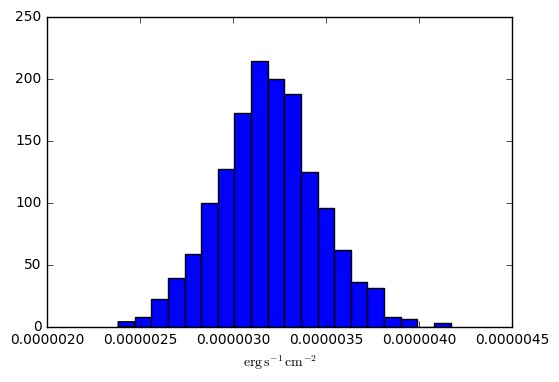

In [15]:
from astropy.visualization import quantity_support

quantity_support()

_=hist(res[1]['flux distribution'][0],bins=20)

#### Components
We can also look at components as before. A dictionary of sources is returned, each containing Dataframes of the components information and distributions.


In [16]:
res = calculate_point_source_flux(10,40000,
                                  bayes,
                                  flux_unit='erg/(s cm2)',
                                  energy_unit='keV',
                                  use_components=True)

,flux,credible region,flux distribution
bn080916009: Blackbody,2.9938763505e-07 erg / (cm2 s),"[2.78837939723e-07 erg / (cm2 s), 3.1812145133...","[2.87053413293e-07 erg / (cm2 s), 2.9046850638..."
bn080916009: Powerlaw,2.88839292881e-06 erg / (cm2 s),"[2.58973345377e-06 erg / (cm2 s), 3.1331205954...","[3.40270647273e-06 erg / (cm2 s), 2.9278670503..."


We can easily now visulaize the flux distribtuions from the individual components.

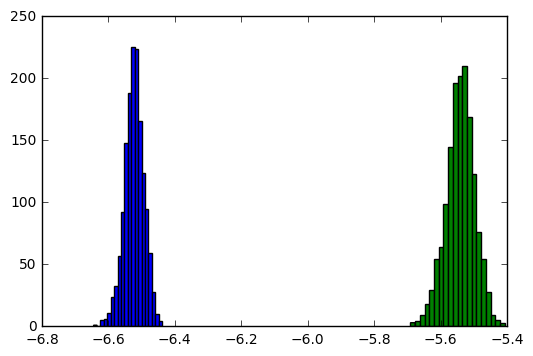

In [18]:
_=hist(log10(res[1]['flux distribution'][0].value),bins=20)
_=hist(log10(res[1]['flux distribution'][1].value),bins=20)



In [20]:
res = calculate_point_source_flux(10,40000,
                                  bayes,jl1,jl2,
                                  flux_unit='erg/(s cm2)',
                                  energy_unit='keV')

,flux,error
bn080916009: total,2.3940884793e-06 erg / (cm2 s),3.19122698073e-07 erg / (cm2 s)
bn080916009_2: total,3.48977700089e-06 erg / (cm2 s),2.94755574958e-07 erg / (cm2 s)


,flux,credible region,flux distribution
bn080916009: total,3.18778056386e-06 erg / (cm2 s),"[2.94636028045e-06 erg / (cm2 s), 3.4673624470...","[3.68975988602e-06 erg / (cm2 s), 3.2183355567..."


In [27]:
cleanup_downloaded_GBM_data(gbm_data)

Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_cspec_n3_bn080916009_v01.pha
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_cspec_n3_bn080916009_v00.rsp2
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_tte_n3_bn080916009_v01.fit.gz
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_cspec_b0_bn080916009_v01.pha
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_cspec_b0_bn080916009_v00.rsp2
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_tte_b0_bn080916009_v01.fit.gz


